# 卒業研究2：分析の限界について
#### 坂西和也

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# CSVファイルを読み込む
data_path = '/home/mori/banzai/banzai_study/masuda/data.csv'
data = pd.read_csv(data_path)

(増田先生より)5列のデータで、最初の列がx軸(速度)、第2列以降がy軸の透過率です。

第2列が本来の(ものに近い)データ、第3-5列が実験条件による「望ましくない影響」を受けてしまったデータです。

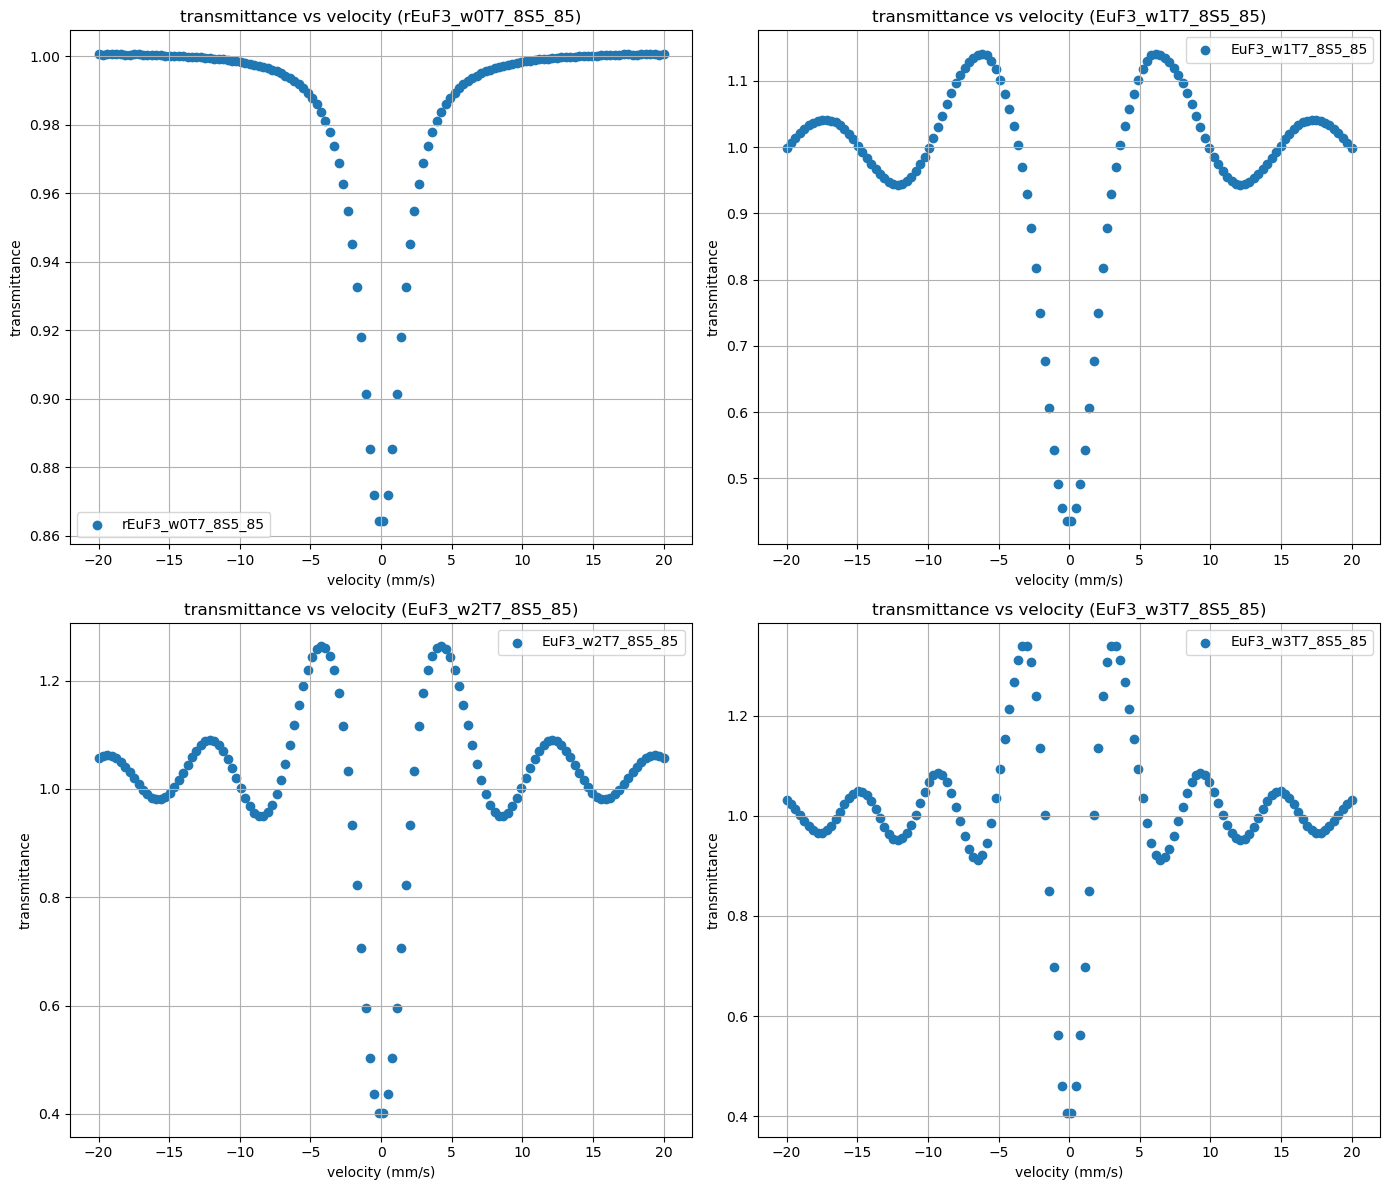

In [3]:
# 2列から5列までのデータをそれぞれ散布図でプロット
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.ravel()

for idx, column in enumerate(data.columns[1:]):
    axes[idx].scatter(data['Velocity (mm/s)'], data[column], label=column)
    axes[idx].set_title(f'transmittance vs velocity ({column})')
    axes[idx].set_xlabel('velocity (mm/s)')
    axes[idx].set_ylabel('transmittance')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [6]:
x = data['Velocity (mm/s)']
l = len(x)
print(l)

128


## 正規乱数の標準偏差を変えて限界を調べる
9月の報告分に変更を加え，正規乱数の標準偏差を変えて限界を調べる．
### ランダムノイズ付加
縦軸1.0とピークとなる値との差と同じ標準偏差とした．

1.$\sigma = 0.14$

2.$\sigma = 0.6$

In [48]:
# 正規ノイズをデータに加える

import numpy as np
import matplotlib.pyplot as plt

# データの生成
np.random.seed(0)

random0 = np.random.normal(loc = 0.0 , scale =  0.14 , size = l)
random1 = np.random.normal(loc = 0.0 , scale =  0.60 , size = l)

data = pd.read_csv(data_path)

y1 = data['rEuF3_w0T7_8S5_85'] + random0
y2 = data['EuF3_w1T7_8S5_85'] + random1
y3 = data['EuF3_w2T7_8S5_85'] + random1
y4 = data['EuF3_w3T7_8S5_85'] + random1

In [49]:
import pandas as pd

data_error3 = pd.DataFrame({
    'Velocity (mm/s)'   : x,
    'rEuF3_w0T7_8S5_85' : y1,
    'EuF3_w1T7_8S5_85'  : y2,
    'EuF3_w2T7_8S5_85'  : y3,
    'EuF3_w3T7_8S5_85'  : y4,
})

In [50]:
data_error3.to_csv('data_error3.csv', index=False)

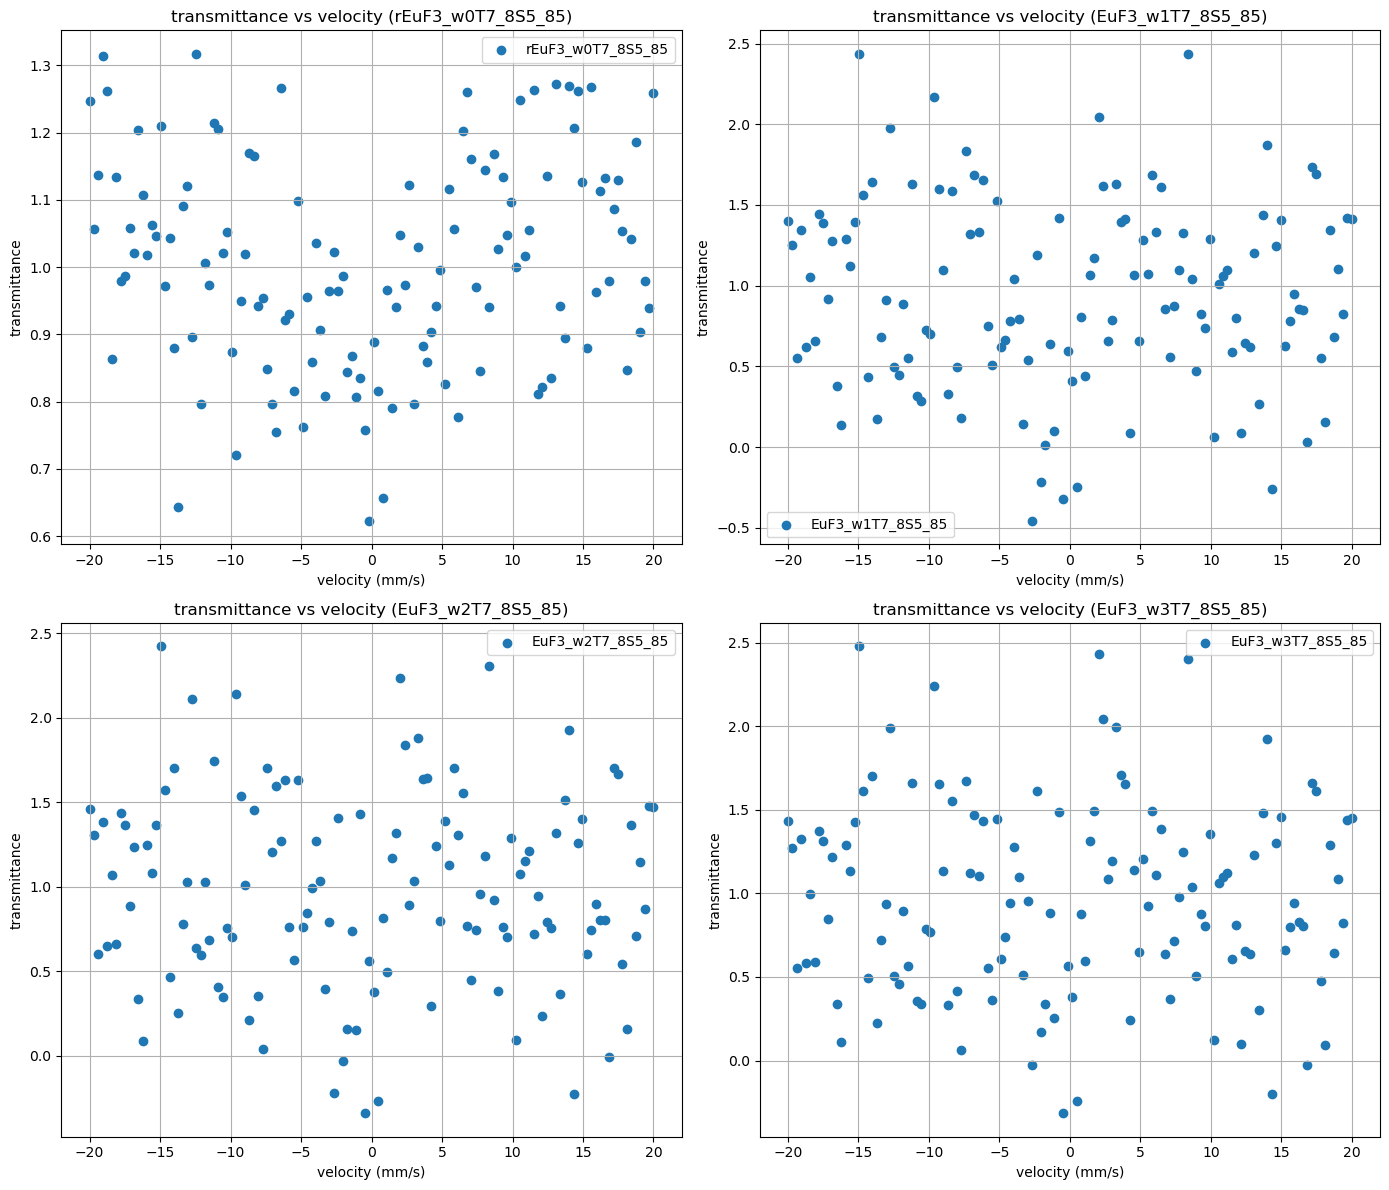

In [51]:
# 2列から5列までのデータをそれぞれ散布図でプロット
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.ravel()

for idx, column in enumerate(data_error3.columns[1:]):
    axes[idx].scatter(data_error3['Velocity (mm/s)'], data_error3[column], label=column)
    axes[idx].set_title(f'transmittance vs velocity ({column})')
    axes[idx].set_xlabel('velocity (mm/s)')
    axes[idx].set_ylabel('transmittance')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()

### ガウス過程回帰で再現

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   1.126296e+02   1.664168e+03 

    00s02  0004  -2.110328e+01   9.186083e+02 
    00s02  0006  -3.930061e+01   2.839914e+01 
    00s04  0014  -5.729667e+01   2.274635e-04 
    00s05  0020  -5.729686e+01   2.787867e-13 
    00s05  0021  -5.729686e+01   2.787867e-13 
Runtime:     00s05
Optimization status: Converged



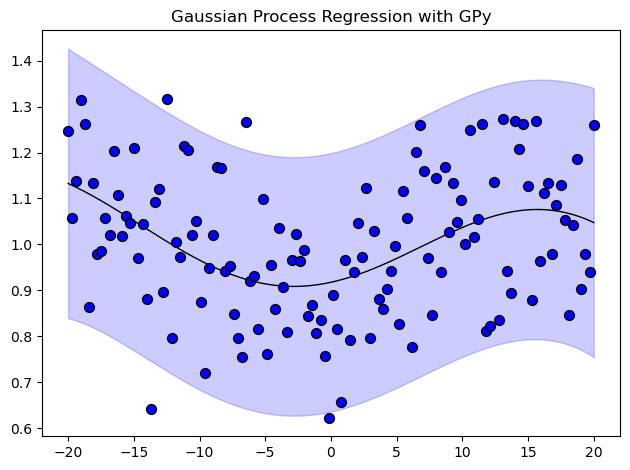

In [52]:
# rEuF3_w0T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error3.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 1].values.reshape(-1, 1)

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy")
plt.tight_layout()
plt.show()


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0008   1.193093e+02   4.736504e-01 
    00s08  0015   1.192226e+02   1.064072e-08 
    00s09  0016   1.192226e+02   1.064072e-08 
Runtime:     00s09
Optimization status: Converged



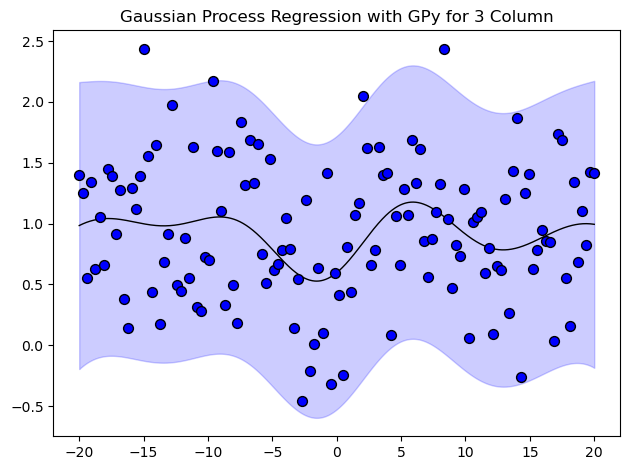

In [53]:
# EuF3_w1T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error3.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 2].values.reshape(-1, 1)  # 3列目のデータを目的変数として使用

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy for 3 Column")
plt.tight_layout()
plt.show()


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0011   1.187963e+02   1.302659e+01 
    00s03  0018   1.139814e+02   1.992014e-03 
    00s05  0022   1.134637e+02   4.176901e-04 
    00s06  0030   1.133448e+02   5.106940e-05 
    00s07  0039   1.133356e+02   1.213735e-05 
    00s07  0041   1.133349e+02   6.423473e-08 
    00s08  0047   1.133345e+02   2.846864e-08 
Runtime:     00s08
Optimization status: Converged



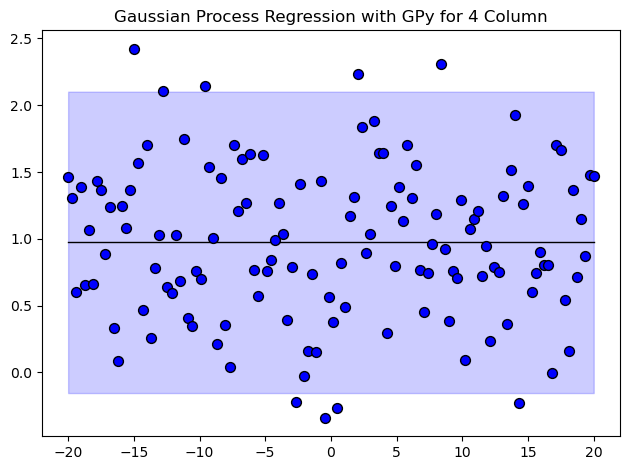

In [54]:
# EuF3_w2T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error3.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 3].values.reshape(-1, 1)  # 3列目のデータを目的変数として使用

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy for 4 Column")
plt.tight_layout()
plt.show()


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0003   3.824441e+02   1.289584e+05 
    00s02  0011   1.183298e+02   3.023238e-01 

    00s02  0013   1.172704e+02   4.315967e+01 
    00s03  0019   1.150735e+02   6.182949e-01 
    00s05  0028   1.140974e+02   1.804742e-03 
    00s07  0033   1.140493e+02   2.569402e-05 
    00s08  0041   1.140332e+02   2.117213e-04 
    00s10  0055   1.140317e+02   5.620043e-10 
    00s11  0060   1.140317e+02   9.313893e-10 
Runtime:     00s11
Optimization status: Converged



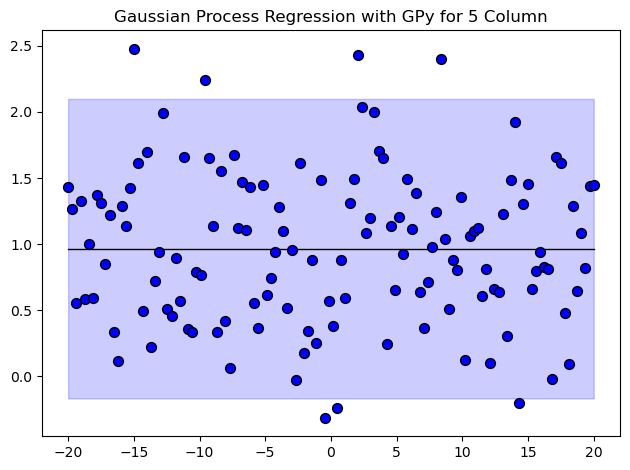

In [55]:
# EuF3_w3T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error3.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 4].values.reshape(-1, 1)  # 3列目のデータを目的変数として使用

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy for 5 Column")
plt.tight_layout()
plt.show()


## さらに標準偏差を大きくしてみる
### ランダムノイズ付加
縦軸1.0とピークとなる値との差の2分の位置を標準偏差とした．

1.$\sigma = 0.28$

2.$\sigma = 1.20$

In [56]:
# 正規ノイズをデータに加える

import numpy as np
import matplotlib.pyplot as plt

# データの生成
np.random.seed(0)

random0 = np.random.normal(loc = 0.0 , scale =  0.28 , size = l)
random1 = np.random.normal(loc = 0.0 , scale =  1.20 , size = l)

data = pd.read_csv(data_path)

y1 = data['rEuF3_w0T7_8S5_85'] + random0
y2 = data['EuF3_w1T7_8S5_85'] + random1
y3 = data['EuF3_w2T7_8S5_85'] + random1
y4 = data['EuF3_w3T7_8S5_85'] + random1

In [57]:
import pandas as pd

data_error4 = pd.DataFrame({
    'Velocity (mm/s)'   : x,
    'rEuF3_w0T7_8S5_85' : y1,
    'EuF3_w1T7_8S5_85'  : y2,
    'EuF3_w2T7_8S5_85'  : y3,
    'EuF3_w3T7_8S5_85'  : y4,
})

In [58]:
data_error4.to_csv('data_error4.csv', index=False)

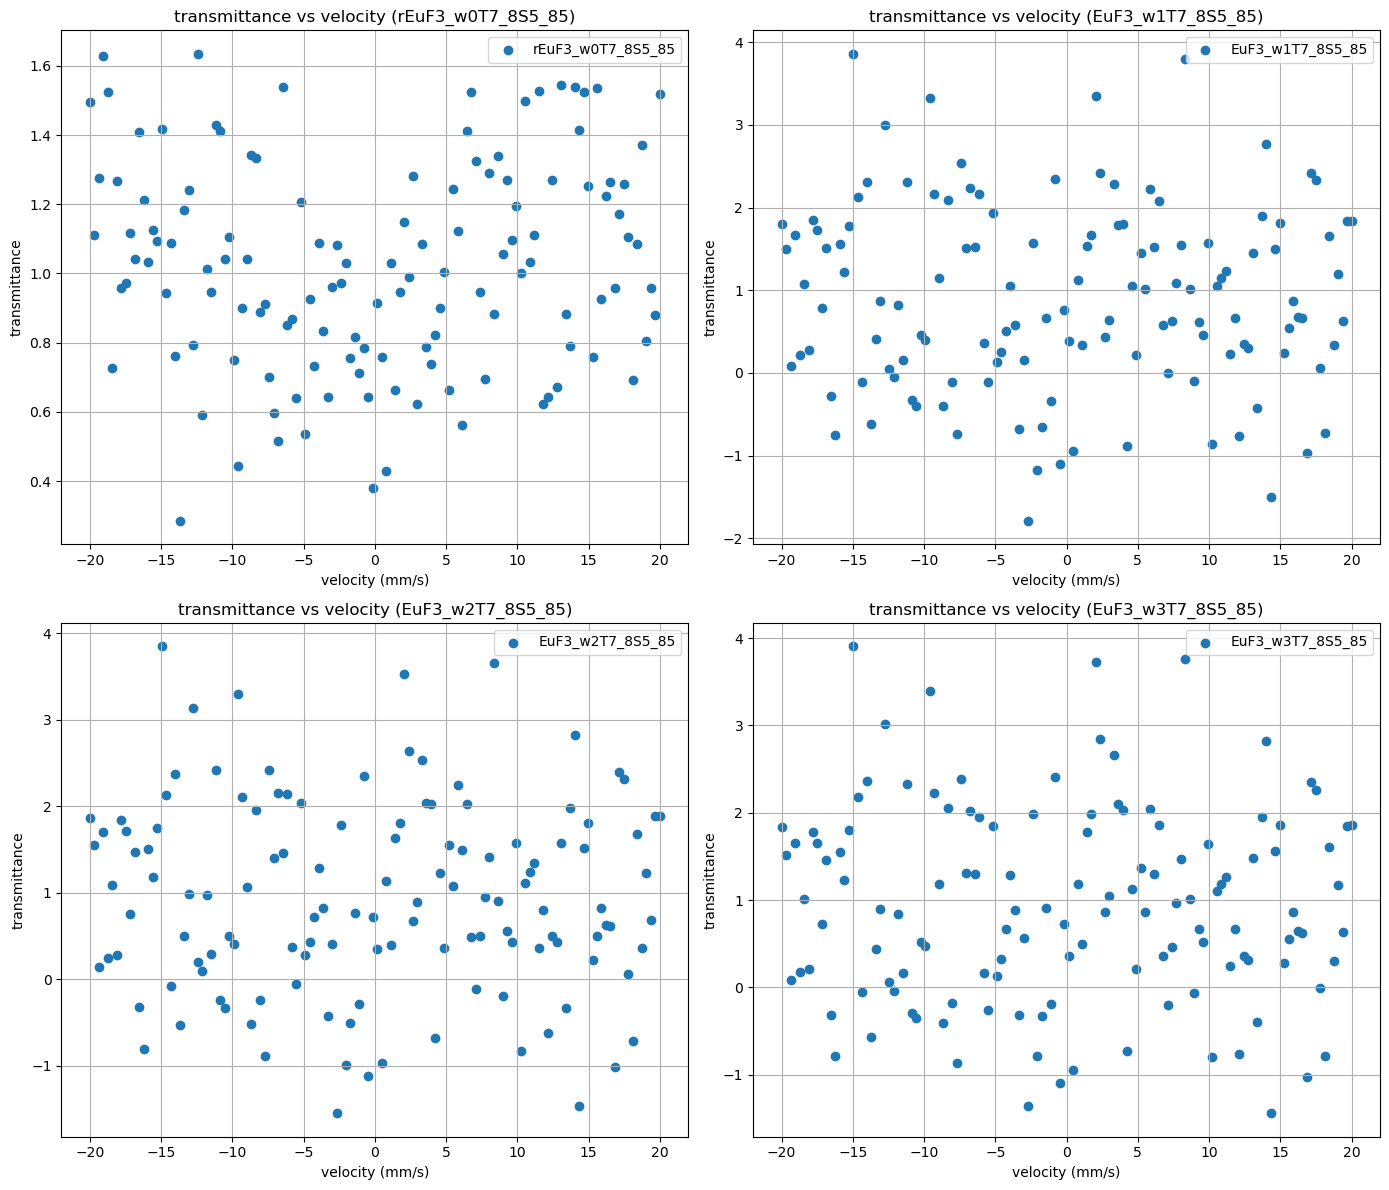

In [59]:
# 2列から5列までのデータをそれぞれ散布図でプロット
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.ravel()

for idx, column in enumerate(data_error4.columns[1:]):
    axes[idx].scatter(data_error4['Velocity (mm/s)'], data_error4[column], label=column)
    axes[idx].set_title(f'transmittance vs velocity ({column})')
    axes[idx].set_xlabel('velocity (mm/s)')
    axes[idx].set_ylabel('transmittance')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()

### ガウス過程回帰で再現

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   1.746105e+02   4.269942e+04 

    00s02  0004   5.955846e+01   3.695634e+02 
    00s02  0006   5.459012e+01   7.725357e+02 
    00s03  0014   2.735292e+01   1.154534e+00 
    00s04  0020   2.733039e+01   2.043305e-05 
    00s04  0023   2.733039e+01   7.085480e-11 
Runtime:     00s04
Optimization status: Converged



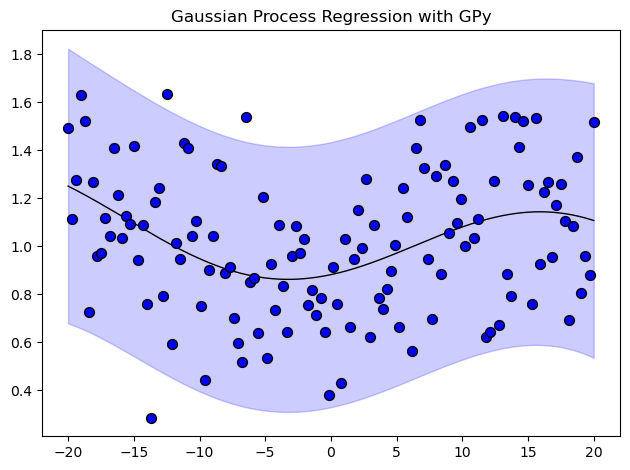

In [60]:
# rEuF3_w0T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error4.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 1].values.reshape(-1, 1)

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy")
plt.tight_layout()
plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0010   2.028735e+02   1.120671e+00 
    00s03  0022   1.989481e+02   7.532973e-03 
    00s03  0025   1.988714e+02   4.625222e-03 

    00s03  0026   1.988611e+02   1.574758e-03 
    00s05  0038   1.988400e+02   3.325659e-05 
    00s06  0050   1.988396e+02   1.350996e-08 
    00s07  0053   1.988396e+02   1.162425e-10 
Runtime:     00s07
Optimization status: Converged



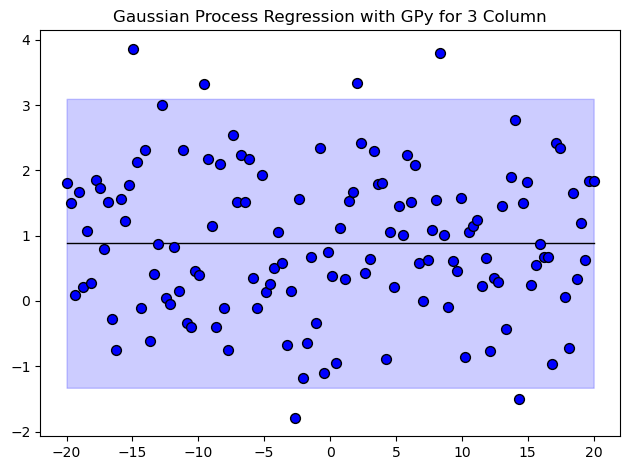

In [61]:
# EuF3_w1T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error4.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 2].values.reshape(-1, 1)  # 3列目のデータを目的変数として使用

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy for 3 Column")
plt.tight_layout()
plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   2.138324e+02   6.829346e+01 
    00s01  0008   2.031545e+02   4.782489e+00 


    00s02  0014   1.991034e+02   6.287631e-01 
    00s03  0024   1.979757e+02   1.279887e-03 
    00s04  0029   1.979543e+02   4.228069e-04 
    00s05  0035   1.979406e+02   2.826972e-06 
    00s05  0038   1.979383e+02   8.590276e-08 
    00s06  0043   1.979379e+02   1.403470e-07 
Runtime:     00s06
Optimization status: Converged



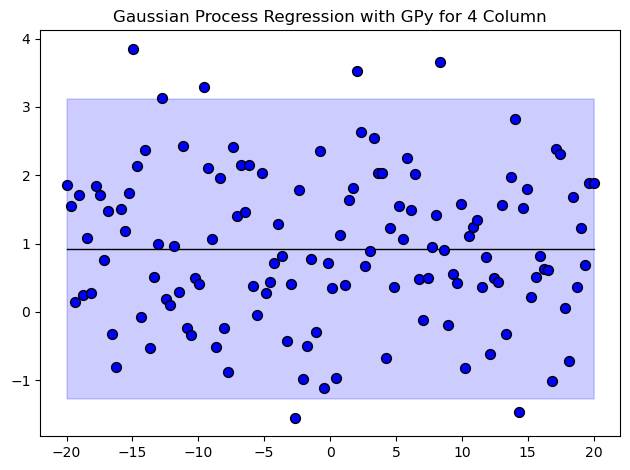

In [62]:
# EuF3_w2T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error4.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 3].values.reshape(-1, 1)  # 3列目のデータを目的変数として使用

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy for 4 Column")
plt.tight_layout()
plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   2.094026e+02   1.768062e+01 
    00s01  0009   2.032040e+02   2.096376e+00 

    00s01  0010   2.024758e+02   8.433547e-02 
    00s02  0021   1.985816e+02   3.917487e-02 
    00s04  0034   1.984228e+02   3.620906e-04 
    00s05  0041   1.984211e+02   1.000978e-07 
    00s06  0047   1.984209e+02   1.251996e-09 
Runtime:     00s06
Optimization status: Converged



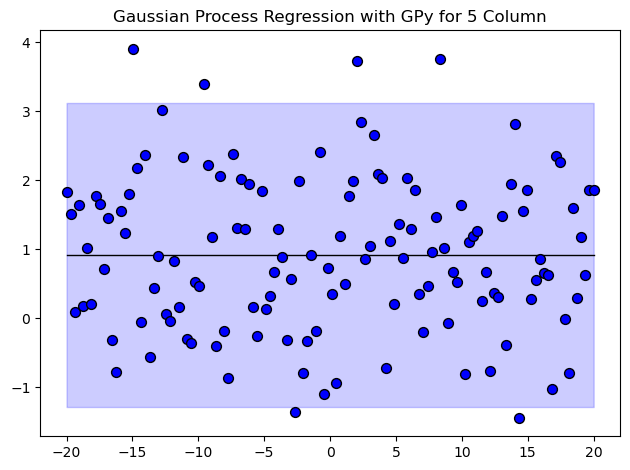

In [63]:
# EuF3_w3T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error4.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 4].values.reshape(-1, 1)  # 3列目のデータを目的変数として使用

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy for 5 Column")
plt.tight_layout()
plt.show()

## np.random.seed(0)を変更してみる

In [76]:
# 正規ノイズをデータに加える

import numpy as np
import matplotlib.pyplot as plt

# データの生成
np.random.seed(12)

random0 = np.random.normal(loc = 0.0 , scale =  0.14 , size = l)
random1 = np.random.normal(loc = 0.0 , scale =  0.60 , size = l)

data = pd.read_csv(data_path)

y1 = data['rEuF3_w0T7_8S5_85'] + random0
y2 = data['EuF3_w1T7_8S5_85'] + random1
y3 = data['EuF3_w2T7_8S5_85'] + random1
y4 = data['EuF3_w3T7_8S5_85'] + random1

In [77]:
import pandas as pd

data_error_random = pd.DataFrame({
    'Velocity (mm/s)'   : x,
    'rEuF3_w0T7_8S5_85' : y1,
    'EuF3_w1T7_8S5_85'  : y2,
    'EuF3_w2T7_8S5_85'  : y3,
    'EuF3_w3T7_8S5_85'  : y4,
})

In [78]:
data_error_random.to_csv('data_error_random.csv', index=False)

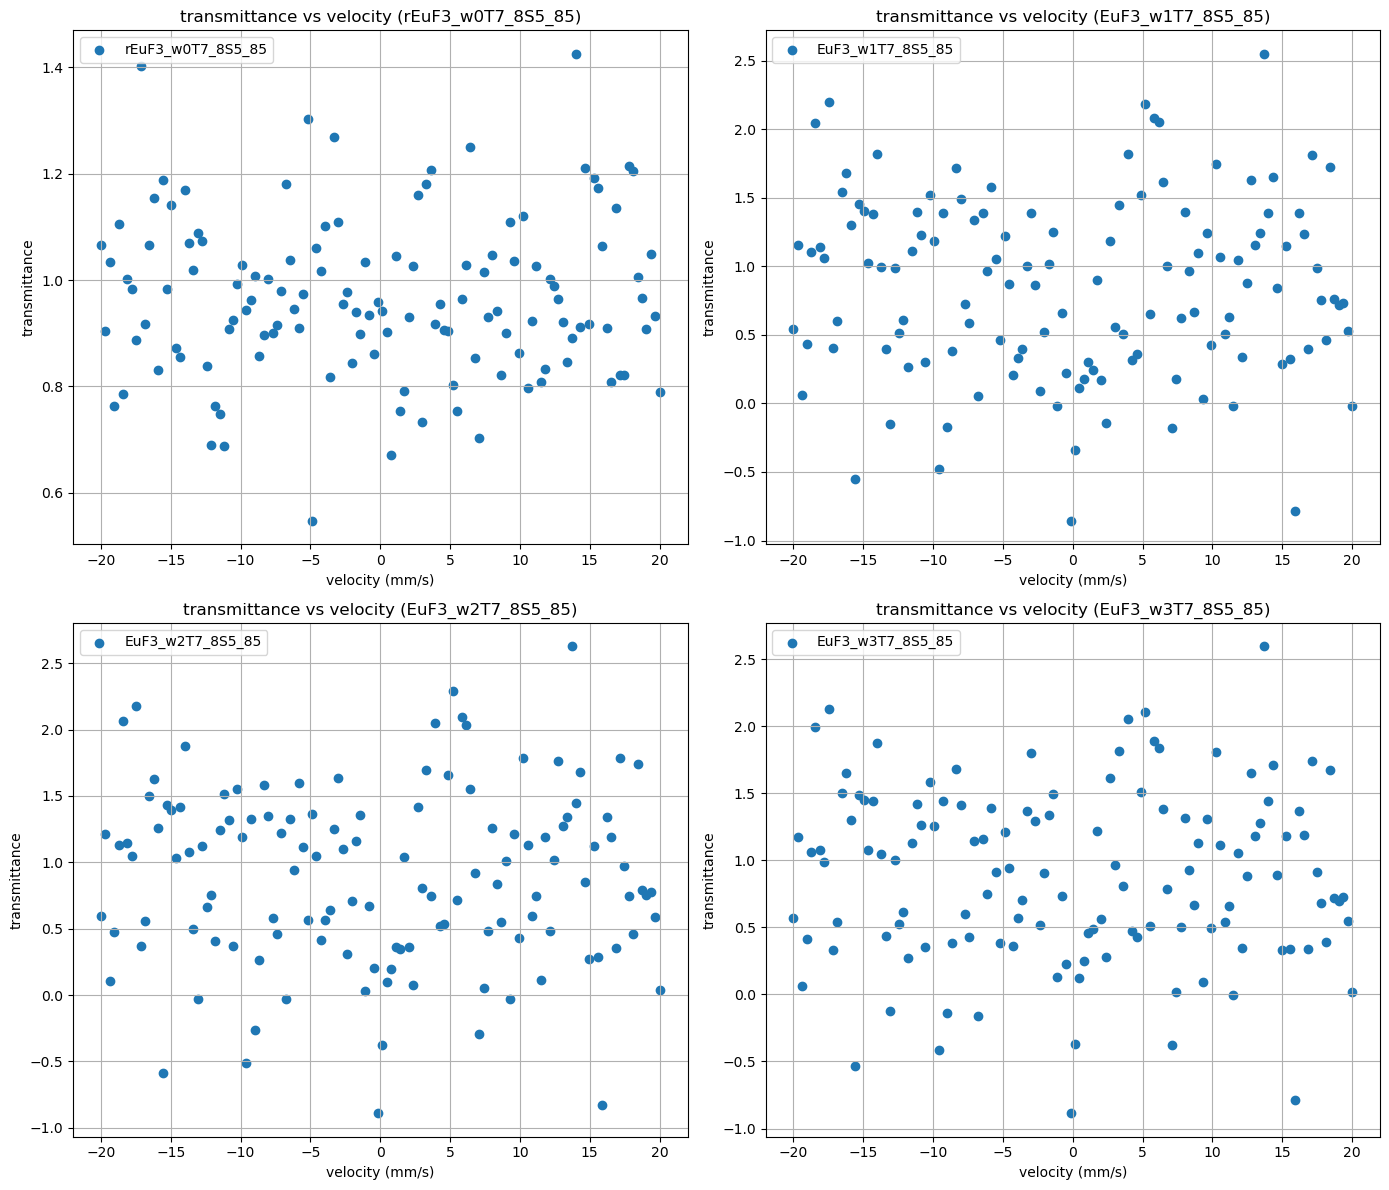

In [79]:
# 2列から5列までのデータをそれぞれ散布図でプロット
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.ravel()

for idx, column in enumerate(data_error_random.columns[1:]):
    axes[idx].scatter(data_error_random['Velocity (mm/s)'], data_error_random[column], label=column)
    axes[idx].set_title(f'transmittance vs velocity ({column})')
    axes[idx].set_xlabel('velocity (mm/s)')
    axes[idx].set_ylabel('transmittance')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()

## ガウス過程回帰で再現

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003  -1.798068e+01   5.167498e+02 

    00s03  0006  -2.734283e+01   9.521042e+01 
    00s04  0010  -4.696099e+01   2.254907e+00 
    00s08  0030  -5.646870e+01   1.684805e+00 
    00s08  0034  -5.670313e+01   2.680453e-01 
    00s09  0040  -5.679084e+01   5.352481e-03 
    00s09  0044  -5.680210e+01   4.070374e-04 
    00s10  0053  -5.681022e+01   2.902112e-06 
Runtime:     00s10
Optimization status: Converged



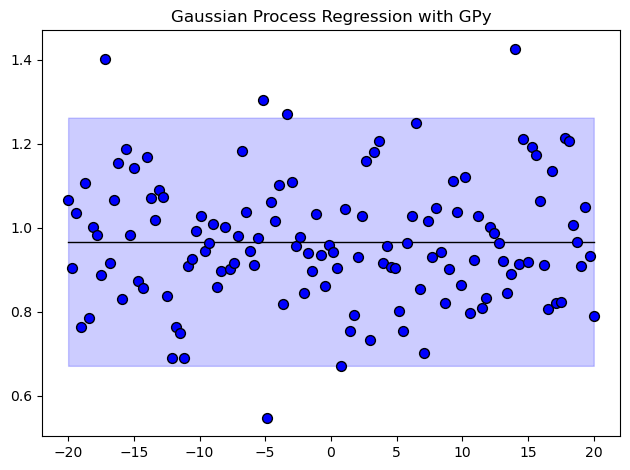

In [80]:

# rEuF3_w0T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error_random.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 1].values.reshape(-1, 1)

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy")
plt.tight_layout()
plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   1.662519e+02   5.177896e+02 
    00s02  0013   1.341688e+02   4.374893e-02 
    00s02  0016   1.341595e+02   4.078588e-09 
    00s02  0018   1.341595e+02   8.531578e-11 


Runtime:     00s02
Optimization status: Converged



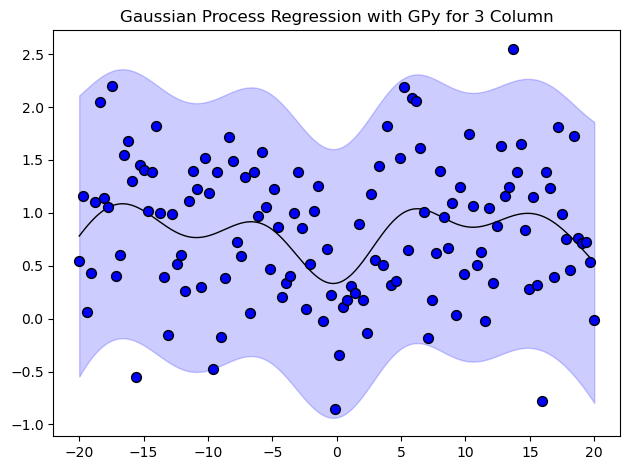

In [81]:
# EuF3_w1T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error_random.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 2].values.reshape(-1, 1)  # 3列目のデータを目的変数として使用

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy for 3 Column")
plt.tight_layout()
plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   1.404765e+02   1.379221e+01 

    00s01  0006   1.397485e+02   4.259283e+00 
    00s04  0015   1.368119e+02   9.609092e-11 
    00s04  0016   1.368119e+02   9.609092e-11 
Runtime:     00s04
Optimization status: Converged



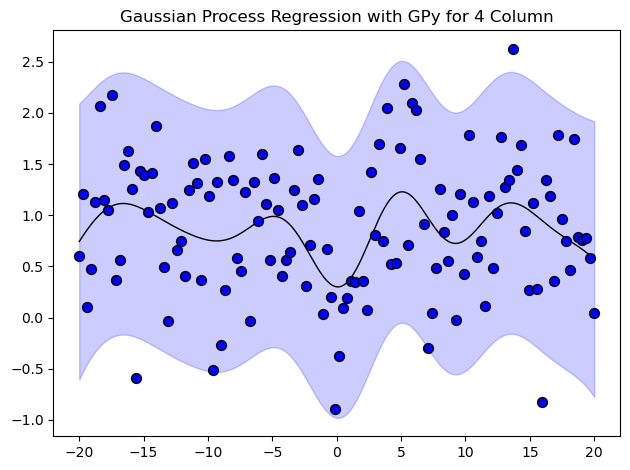

In [82]:
# EuF3_w2T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error_random.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 3].values.reshape(-1, 1)  # 3列目のデータを目的変数として使用

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy for 4 Column")
plt.tight_layout()
plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   1.666912e+02   5.164998e+02 
    00s01  0008   1.407494e+02   1.309644e+02 
    00s01  0009   1.382404e+02   2.557228e+01 

    00s03  0023   1.303033e+02   1.954754e-01 
    00s04  0028   1.295503e+02   1.124252e-02 
    00s05  0035   1.295296e+02   1.012590e-01 
    00s06  0040   1.294200e+02   5.913256e-06 
    00s06  0043   1.522436e+02   5.658603e+02 
    00s07  0045   1.294171e+02   9.168370e-07 
Runtime:     00s07
Optimization status: Converged



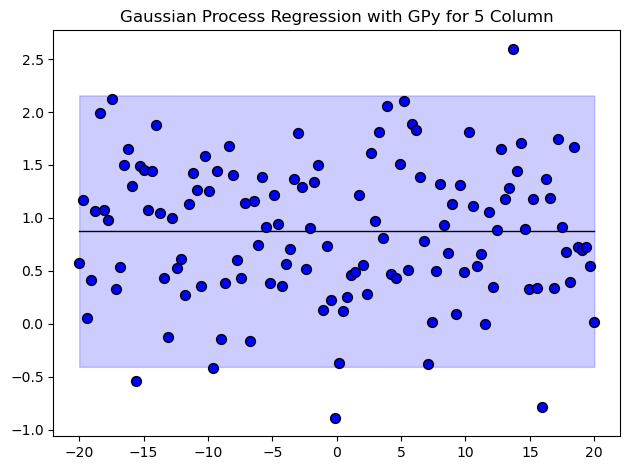

In [83]:
# EuF3_w3T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_error_random.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 4].values.reshape(-1, 1)  # 3列目のデータを目的変数として使用

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy for 5 Column")
plt.tight_layout()
plt.show()